In [1]:
# !conda install scipy -y

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from Utils.utilities import *
import h5py
from scipy.stats import zscore
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from models.cnn2d_lstm import CNN2D_LSTM_Net
from models.cnn1d_lstm import CNN_LSTM_Net
from models.tinny import TinyMEGNet, MEGNet

In [3]:
set_seed(42) 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Use os.path.join() to create the correct file path
filepath = get_filepath()
print(f"Base filepath: {filepath}")

# Example usage for Intra-subject classification
intra_train_path = os.path.join(filepath, "Intra", "train")
intra_test_path = os.path.join(filepath, "Intra", "test")

# Load a small subset of files to test the function
# Downsample factor is set to 16 to speed up the process, CHANGE LATER!
train_raw, train_labels = load_h5_files(intra_train_path)
test_raw, test_labels = load_h5_files(intra_test_path)

train_data = normalize_meg_data(train_raw, downsample_factor=4)
test_data = normalize_meg_data(test_raw, downsample_factor=4) # I think this is NOT okay, we should normalize test data with the same parameters as train data

"""
1. Normalize a list of MEG matrices using z-score normalization per channel.
2. Optionally downsample the data by a specified factor.   
        According to the project document, the MEG data is recorded at 2034 Hz — that is, 2034 samples per second
        The Nyquist theorem says you must sample at least twice the highest frequency present in your signal to avoid losing information.
        MEG signals of interest often contain activity up to about 100 Hz (sometimes more for very fast neural activity).
        So a downsampled rate of 200–500 Hz is usually sufficient.
        From 2034 Hz, you might consider downsampling to:
            508.5 Hz (divide by 4)
            406.8 Hz (divide by 5)
            203.4 Hz (divide by 10)
"""

Base filepath: c:\Users\marcd\Desktop\Master\Courses\Deep_Learning\Project_2\Final Project data\Final Project data


'\n1. Normalize a list of MEG matrices using z-score normalization per channel.\n2. Optionally downsample the data by a specified factor.   \n        According to the project document, the MEG data is recorded at 2034 Hz — that is, 2034 samples per second\n        The Nyquist theorem says you must sample at least twice the highest frequency present in your signal to avoid losing information.\n        MEG signals of interest often contain activity up to about 100 Hz (sometimes more for very fast neural activity).\n        So a downsampled rate of 200–500 Hz is usually sufficient.\n        From 2034 Hz, you might consider downsampling to:\n            508.5 Hz (divide by 4)\n            406.8 Hz (divide by 5)\n            203.4 Hz (divide by 10)\n'

In [6]:
# Check training set size and distribution
print(f"--- Training/val samples: {len(train_data)} ---")
print("label distribution:")
for label in set(train_labels):
    count = train_labels.count(label)
    print(f"  {label}: {count}")

# Check sample shapes
if train_data:
    print(f"Shape of one training sample: {train_data[0].shape}")

print(f"\n--- Test samples: {len(test_data)} ---")
print("label distribution:")
for label in set(test_labels):
    count = test_labels.count(label)
    print(f"  {label}: {count}")

if test_data:
    print(f"Shape of one test sample: {test_data[0].shape}")

--- Training/val samples: 32 ---
label distribution:
  rest: 8
  task_story: 8
  task_working: 8
  task_motor: 8
Shape of one training sample: (248, 8906)

--- Test samples: 8 ---
label distribution:
  rest: 2
  task_story: 2
  task_working: 2
  task_motor: 2
Shape of one test sample: (248, 8906)


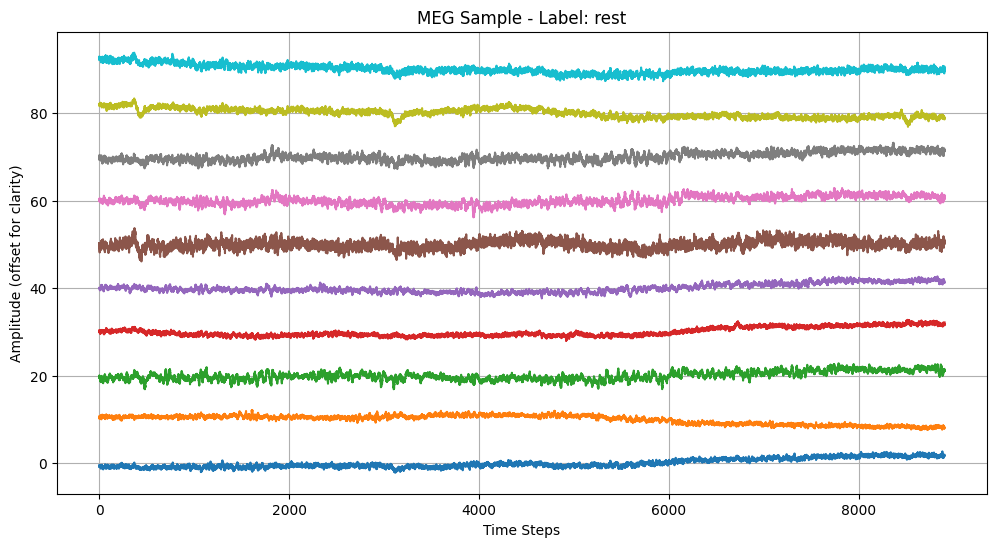

In [7]:
plot_meg_sample(train_data[0], train_labels[0])

In [8]:
# class mapping for MEG tasks

LABEL_MAP = {
    'rest': 0,
    'task_motor': 1, 
    'task_story': 2,
    'task_working': 3
}

In [9]:
train_data_split, val_data_split, train_labels_split, val_labels_split = train_test_split(
    train_data,
    train_labels,
    test_size=0.25,           # % for validation
    stratify=train_labels,    # Optional: maintain class balance
    random_state=42
)

trainloader = create_dataloaders(train_data_split, train_labels_split, LABEL_MAP, batch_size=4, suffle=True, num_workers=0)
valloader   = create_dataloaders(val_data_split, val_labels_split, LABEL_MAP, batch_size=4, suffle=False, num_workers=0)
testloader  = create_dataloaders(test_data, test_labels, LABEL_MAP, batch_size=4, suffle=False, num_workers=0)

print(f"Train batches: {len(trainloader)}, Val batches: {len(valloader)}, Test batches: {len(testloader)}")



Train batches: 6, Val batches: 2, Test batches: 2


### HyperParameters to play with

In [10]:
CONFIG = {
    # General
    "num_classes": len(LABEL_MAP),
    "input_sensors": 248,
    "input_time_steps": train_data[0].shape[1],
    
    # Training
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "patience": 12,
    "epochs": 50,
    "seed": 42,
    
    # CNN2D_LSTM_Net-specific
    "lstm_hidden_size": 64,
    "num_lstm_layers": 2,
    "dropout": 0.3,
}


In [11]:
model_Tiny_fn = lambda: TinyMEGNet(
    num_classes=len(LABEL_MAP),
    input_channels=248,
    input_time_steps=train_data[0].shape[1]
)

model_CNN_LSTM_fn = lambda: CNN_LSTM_Net(
    num_classes=len(LABEL_MAP),
    input_sensors=248,
    input_time_steps=train_data[0].shape[1]
)

CNN2D_LSTM_Net_fn = lambda: CNN2D_LSTM_Net(
    num_classes       = CONFIG["num_classes"],
    input_sensors     = CONFIG["input_sensors"],
    input_time_steps  = CONFIG["input_time_steps"],
    lstm_hidden_size  = CONFIG["lstm_hidden_size"],
    num_lstm_layers   = CONFIG["num_lstm_layers"],
    dropout           = CONFIG["dropout"],
)

In [12]:
model = model_Tiny_fn()
print(f"Model created. Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model input shape expected: (batch, 1, 248, {train_data[0].shape[1]})")

TinyMEGNet created with 9,264 parameters
Model created. Total parameters: 9,264
Model input shape expected: (batch, 1, 248, 8906)


In [13]:
results = train_val_experiment(
    trainloader,
    valloader,
    CNN2D_LSTM_Net_fn,
    LABEL_MAP,
    lr=CONFIG["lr"], 
    weight_decay=CONFIG["weight_decay"],
    epochs=CONFIG["epochs"],
    patience=CONFIG["patience"],
    seed=CONFIG["seed"],
)

2D CNN + LSTM Net initialized:
  - LSTM input size: 3968
  - Sequence length: 594
  - Parameters: 2,269,700
Epoch 0: Train Acc=0.250, Val Acc=0.250
Epoch 10: Train Acc=0.792, Val Acc=0.500
Epoch 20: Train Acc=0.958, Val Acc=0.625
Early stopping at epoch 20



  TRAIN/VALIDATION RESULTS SUMMARY

📈 Best Validation Accuracy: 0.8750


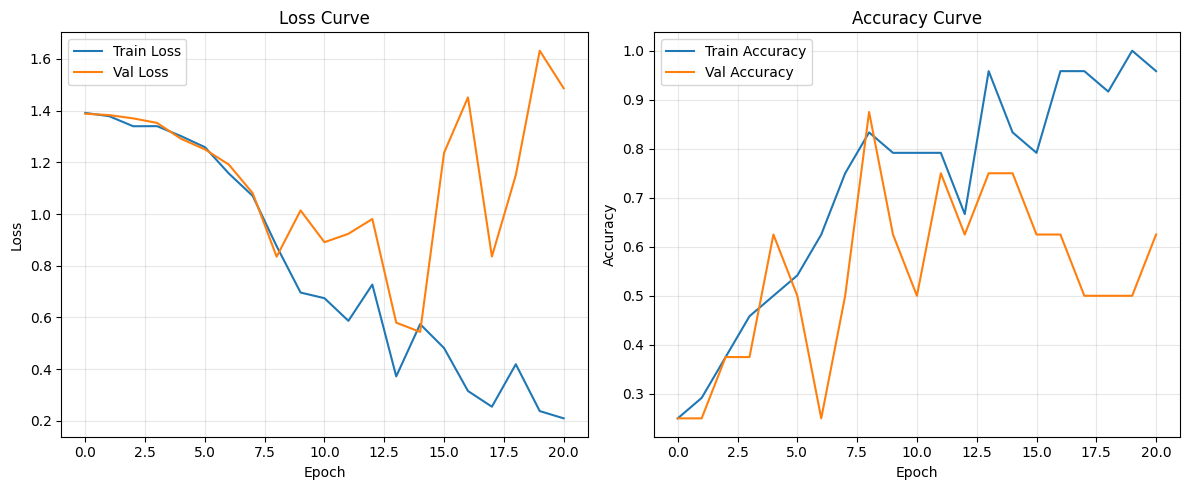

In [14]:
analyze_train_val_results(results)